In [39]:
import pymongo
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

In [2]:
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [8]:
db = client.testdb
tripadvisor = db.tripadvisor
yelp = db.yelp

In [87]:
# grab from mongo, sort by date, rename index to 'order' of appearance
df = pd.DataFrame(list(yelp.find()))
df = df.drop('_id', 1)
df = df.sort_values('date').reset_index()
df.columns = ['order' if x=='index' else x for x in df.columns]
df.head()

,order,date,id,rating,text,userlocation,username
0,1550,2006-12-05,F41LRfdyzj4yagcDVsIS7g,4,"I guess the ""Tavern"" in the name refers to the...","\nFairfax, VA\n",Gayle G.
1,1782,2006-12-18,QNJmkKw9hxN74IDCNLMEkg,5,If you think this restaurant serving an Asian ...,"\nWashington, DC\n",Lydia P.
2,2038,2007-01-09,FqptloYidzdvoratrazZ0w,3,An interesting experience but nothing spectacu...,"\nToronto, Canada\n",Hratch P.
3,1783,2007-04-23,aSvpHZYUXAdCMKbnF4iyKg,5,The only restaurant in DC I give a 5-star. I h...,"\nArlington, VA\n",Haesung H.
4,1817,2007-05-21,UxpWvr2L7mzn8hY0iQDAoA,5,I loved this restaurant. The interior is beau...,"\nAlexandria, VA\n",Beth F.


In [114]:
# group by date with monthly average
df1 = df.groupby(pd.Grouper(key='date', freq='1M')).mean()
df1 = df1[['rating']]
df1.head()

,rating
date,
2006-12-31,4.5
2007-01-31,3.0
2007-02-28,NaN
2007-03-31,NaN
2007-04-30,5.0


In [115]:
# add missing values
df1 = (df1
       .resample('M')
       .mean()
       .interpolate('linear'))
df1.head()

,rating
date,
2006-12-31,4.500000
2007-01-31,3.000000
2007-02-28,3.666667
2007-03-31,4.333333
2007-04-30,5.000000


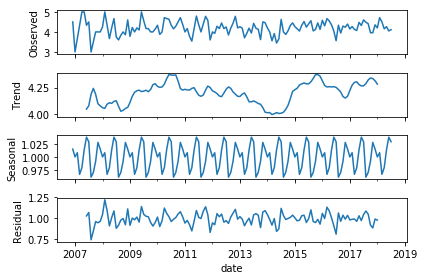

In [112]:
# decompose data
series = df1
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
result.plot()
pyplot.show()

In [116]:
df1 = df1.reset_index()
df1.head()

,date,rating
0,2006-12-31,4.500000
1,2007-01-31,3.000000
2,2007-02-28,3.666667
3,2007-03-31,4.333333
4,2007-04-30,5.000000


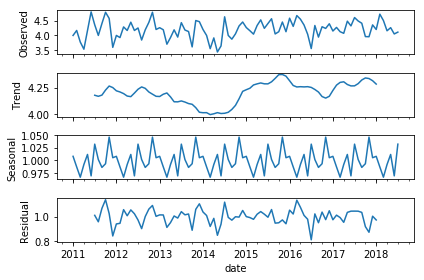

In [117]:
# decompose from 2011
series = df1.loc[df1['date'] > '2011-01-01'].set_index('date')
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
result.plot()
pyplot.show()


In [123]:
print(result.resid)

              rating
date                
2011-01-31       NaN
2011-02-28       NaN
2011-03-31       NaN
2011-04-30       NaN
2011-05-31       NaN
2011-06-30       NaN
2011-07-31  1.010395
2011-08-31  0.957866
2011-09-30  1.067268
2011-10-31  1.137602
2011-11-30  1.024873
2011-12-31  0.842437
2012-01-31  0.940229
2012-02-29  0.945326
2012-03-31  1.056652
2012-04-30  1.007015
2012-05-31  1.054593
2012-06-30  1.023345
2012-07-31  0.972455
2012-08-31  0.902006
2012-09-30  1.000545
2012-10-31  1.061101
2012-11-30  1.090666
2012-12-31  1.002168
2013-01-31  1.013993
2013-02-28  1.013421
2013-03-31  0.912432
2013-04-30  0.951250
2013-05-31  1.005219
2013-06-30  0.988138
...              ...
2016-02-29  1.021006
2016-03-31  1.133762
2016-04-30  1.075919
2016-05-31  1.010030
2016-06-30  0.978680
2016-07-31  0.811268
2016-08-31  1.021991
2016-09-30  0.950230
2016-10-31  1.036794
2016-11-30  0.975369
2016-12-31  1.047757
2017-01-31  0.974220
2017-02-28  1.011884
2017-03-31  0.992174
2017-04-30  0